# RDI sensitivity study

The purpose is to investigate how small shifts in the sampling of the reference PSF affect the RDI suppression. Try this for multiple lenslet sampling parameters.

The steps are:
1. Propagate the reference and target cube at the desired sampling and offset
2. Sum all the cubes, reduce into IFS cubes, and countershift the reference
3. Subtract the reference from the target using least-squares
4. Apply a SPC matched filter to all the points in the bowtie mask to make a noise map
5. Calculate the standard deviation within the bowtie mask

## Load program

In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
import sys
import os

folder = '../../../../crispy'
print(folder)
if folder not in sys.path: sys.path.append(folder)

from crispy.params import Params
folder = '../../../crispy'

from crispy.tools.initLogger import getLogger
log = getLogger('crispy')
from crispy.IFS import polychromeIFS
from crispy.IFS import reduceIFSMap
from crispy.tools.imgtools import scale2imgs,bowtie
from crispy.tools.image import Image
from crispy.tools.rotate import rotateCube,shiftCube
from crispy.tools.postprocessing import mf,recenter_offaxis
from crispy.tools.inputScene import adjust_krist_header
from crispy.tools.detector import averageDetectorReadout
from astropy.io import fits
from crispy.tools.postprocessing import construct_mflib,convolved_mf

par = Params(folder)


Populating the interactive namespace from numpy and matplotlib
../../../../crispy


## Noiseless case

For now, lamc=770nm, sampling is 2 lenslets per lamoD at 660nm. This is the nominal case of everything aligned together.

In [5]:
import glob
# indicate no noise
par.nonoise=True
#ave_target_inputs = glob.glob("/Users/mrizzo/IFS/OS5/*targetstar*")
#ave_targetlist = averageDetectorReadout(par,ave_target_inputs,"/Users/mrizzo/IFS/OS5/OS5_detector")   

# average all the off-axis images (since there is no noise, it is fine to do this)
ave_target = np.zeros(fits.open(ave_targetlist[0])[1].data.shape)
for targetfile in ave_targetlist:
    ave_target += fits.open(targetfile)[1].data
target = Image(data = ave_target)
target.write(par.exportDir+"/target_average_detector.fits",clobber=True)

# reduce the offaxis PSF
offaxis_reduced = reduceIFSMap(par,par.exportDir+"/target_average_detector.fits")


crispy - INFO - Writing data to ../../../crispy/SimResults/target_average_detector.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/target_average_detector.fits
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/target_average_detector_red_optext.fits
crispy - INFO - Elapsed time: 1.355522s


#### Calculate least squares difference with no shift

In [6]:
# for this first test, we already have the ref and target
ref = Image(par.exportDir+"/average_ref_star_detector_red_optext.fits")
target = Image(par.exportDir+"/target_average_detector_red_optext.fits")
lamc = 770.
IWA=3.
OWA=9.
ydim,xdim = target.data[0].shape
mask,scratch = bowtie(target.data[0],ydim//2,xdim//2,openingAngle=65,
            clocking=-par.philens*180./np.pi,
            IWApix=IWA*lamc/par.lenslet_wav/par.lenslet_sampling,
            OWApix=OWA*lamc/par.lenslet_wav/par.lenslet_sampling,
            export=None,twomasks=False)    
coefs,diff = scale2imgs(target,ref,mask=mask,returndiff = True)
Image(data=diff).write(par.exportDir+"/test_lstsqdiff.fits")

crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/average_ref_star_detector_red_optext.fits
crispy - INFO - Read inverse variance from HDU 2 of ../../../crispy/SimResults/average_ref_star_detector_red_optext.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/target_average_detector_red_optext.fits
crispy - INFO - Read inverse variance from HDU 2 of ../../../crispy/SimResults/target_average_detector_red_optext.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/test_lstsqdiff.fits


#### Calculate matched filter library if not already done (this is only for the off axis PSF)

In [3]:

recenter_offaxis('/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits',0.01,par.exportDir+'/centered_offaxis.fits')
centered_offaxis_file = Image(par.exportDir+'/centered_offaxis.fits')
adjust_krist_header(centered_offaxis_file,lamc=770.)
par.saveDetector=False  
Nlam = centered_offaxis_file.data.shape[0]
BW=0.18
lamc=770.
lamlist = lamc*np.linspace(1.-BW/2.,1.+BW/2.,Nlam)

# propagate the offaxis PSF
detectorFrame = polychromeIFS(par,lamlist,centered_offaxis_file,QE=True)
Image(data = detectorFrame,header=par.hdr).write(par.exportDir+"/offaxis_detector.fits",clobber=True)

# reduce the offaxis PSF
offaxis_reduced = reduceIFSMap(par,par.exportDir+"/offaxis_detector.fits")

# construct matched filter
psf = Image(par.exportDir+"/offaxis_detector_red_optext.fits")
construct_mflib(par,psf,IWA=3,OWA=9,lamc=770.,threshold=0.5,mask=mask)

crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits
crispy - INFO - Read data from HDU 0 of ../../../crispy/SimResults/centered_offaxis.fits
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Done.
crispy - INFO - Performance: 3 seconds total
crispy - INFO - Writing data to ../../../crispy/SimResults/offaxis_detector.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/offaxis_detector.fits
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/offaxis_detector_red_optext.fits
crispy - INFO - Elapsed time: 1.259323s
crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/offaxis_detector_red_optext.fits
crispy - INFO - Read inverse variance from HDU 2 of ../../../crispy/SimResults/offaxis_detector_red_optext

#### Convolve the residuals with the matched filter

In [8]:
from crispy.tools.postprocessing import construct_mflib,convolved_mf
convolved = convolved_mf(diff,par.exportDir+'/mflib.fits.gz')
outkey = fits.HDUList(fits.PrimaryHDU(convolved.astype(np.float)))
outkey.writeto(par.exportDir+'/mfcube.fits',clobber=True)
pixstd = [np.nanstd(convolved[i]) for i in range(diff.shape[0])]
print pixstd

[1.7168097519661258, 1.6660121387908129, 1.2435240050378145, 0.99629626137122917, 0.74855159527956305, 0.64275635137042286, 0.63140918515849054, 0.60633286597771596, 0.52804553106159402, 0.47244212644593786, 0.53084317789441537, 0.62920113463893235, 0.67907095197593526, 0.67449579617922417, 0.63312677329336242, 0.58389230479131682, 0.49821344921636657, 0.39529055293895271, 0.29778773506627187]


#### Test shifting IFS cube 

In [16]:
psf = Image(par.exportDir+"/offaxis_detector_red_optext.fits")
shifted = Image(data=shiftCube(psf.data,dx=1.0*np.cos(par.philens),dy=-1.0*np.sin(par.philens),order=1))
shifted.write(par.exportDir+"/test_shift_diag1.0.fits")

crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/offaxis_detector_red_optext.fits
crispy - INFO - Read inverse variance from HDU 2 of ../../../crispy/SimResults/offaxis_detector_red_optext.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/test_shift_diag1.0.fits


# Integrated RDi sensitivity function

In [2]:
from crispy.tools.postprocessing import RDI_noise
offset = [0.5,0.5]
pixstd = RDI_noise(par,offset[0],offset[1],order=3,rootname='test_x%.1f_y%.1f' % (offset[0],offset[1]),
                process_cubes=False,
                countershift=True,
                outdir_time_series = '/Users/mrizzo/IFS/OS5_RDI/',
                outdir_detector='/Users/mrizzo/IFS/OS5_RDI/detector',
                outdir_average='/Users/mrizzo/IFS/OS5_RDI/average',
)

crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_001.fits
crispy - INFO - Apply detector readout on os5_spc_001_refstar_IFS.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_RDI//os5_spc_001_refstar_IFS.fits
crispy - INFO - Writing data to /Users/mrizzo/IFS/OS5_RDI/detector/os5_spc_001_refstar_IFS_detector.fits
crispy - INFO - Apply detector readout on os5_spc_002_refstar_IFS.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_RDI//os5_spc_002_refstar_IFS.fits
crispy - INFO - Writing data to /Users/mrizzo/IFS/OS5_RDI/detector/os5_spc_002_refstar_IFS_detector.fits
crispy - INFO - Apply detector readout on os5_spc_003_refstar_IFS.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_RDI//os5_spc_003_refstar_IFS.fits
crispy - INFO - Writing data to /Users/mrizzo/IFS/OS5_RDI/detector/os5_spc_003_refstar_IFS_detector.fits
crispy - INFO - Apply detector readout on os5_spc_004_refstar_IFS.fits
crispy - INFO - Read da

In [6]:
print pixstd

[22.364910067938453, 12.972331031006007, 8.0740481177586645, 7.979165396343789, 8.4926742707260452, 8.6102006854325275, 8.1480977471437992, 7.0894876712237984, 6.0603253594969804, 5.5616480812671698, 5.7892257369662907, 7.6318266930935978, 10.344853382707687, 12.142851676465808, 11.906301749038859, 10.107246161563621, 8.937605645825407, 9.8547265550383791, 9.3261239462479359]


### Loop on cases

In [ ]:
from crispy.tools.postprocessing import RDI_noise
offset = [0.1,0.2,0.4,0.6,0.8,1.]
results = np.zeros((19,len(offset),len(offset)))
for i in range(len(offset)):
    for j in range(len(offset)):
        results[:,i,j] = RDI_noise(par,offset[i],offset[j],rootname='x%.1f_y%.1f' % (offset[i],offset[j]),
                    process_cubes=True,
                    countershift=True,
                    outdir_time_series = '/Users/mrizzo/IFS/OS5_RDI/',
                    outdir_detector='/Users/mrizzo/IFS/OS5_RDI/detector',
                    outdir_average='/Users/mrizzo/IFS/OS5_RDI/average')
outkey = fits.HDUList(fits.PrimaryHDU(results.astype(np.float)))
outkey.writeto(par.exportDir+'/results_rdi.fits',clobber=True)


crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_001.fits
crispy - INFO - Processing file os5_spc_001.fits
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Done.
crispy - INFO - Performance: 56 seconds total
crispy - INFO - Writing data to /Users/mrizzo/IFS/OS5_RDI//os5_spc_001_refstar_IFS.fits
crispy - INFO - Processing file os5_spc_002.fits
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Done.
crispy - INFO - Performance: 56 seconds total
crispy - INFO - Writing data to /Users/mrizzo/IFS/OS5_RDI//os5_spc_002_refstar_IFS.fits
crispy - INFO - Processing file os5_spc_003.fits
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - I

crispy - INFO - Read data from HDU 0 of ../../../crispy/SimResults/results_rdi.fits


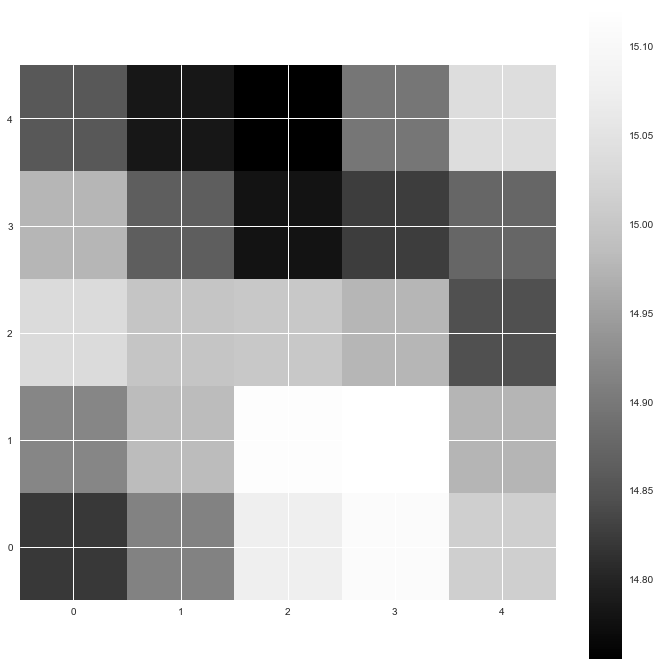

In [11]:
plt.figure(figsize=(12,12))
results=Image(par.exportDir+'/results_rdi.fits').data
plt.imshow(results[-1],cmap='Greys_r')
plt.colorbar()

# Simulation with multiple focal plane sampling parameters

In [ ]:
par.wavecalDir = self.prefix+'/wavecalR50_660/'
sampling = [2.2,2.0,1.8,1.6,1.4,1.2] # lambda/D per pixel
offset = [0.0,0.25,0.5,0.75,1.0]     # in lenslets
Nslices = 20                         # Number of slices in the cube
results = np.zeros((len(sampling),Nslices,len(offset),len(offset)))
for si in range(len(sampling)):
    par.lenslet_sampling = 1./sampling[si]
    print("Adopting sampling",par.lenslet_sampling)
    for i in range(len(offset)):
        for j in range(len(offset)):
            results[si,:,i,j] = RDI_noise(par,offset[i],offset[j],rootname='samp%.1fx%.2f_y%.2f' % (s,offset[i],offset[j]),
                        process_cubes=True,
                        countershift=True,
                        outdir_time_series = '/Users/mrizzo/IFS/OS5_RDI/',
                        outdir_detector='/Users/mrizzo/IFS/OS5_RDI/detector',
                        outdir_average='/Users/mrizzo/IFS/OS5_RDI/average')
outkey = fits.HDUList(fits.PrimaryHDU(results.astype(np.float)))
outkey.writeto(par.exportDir+'/results_rdi_sampling.fits',clobber=True)
